In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
## utility functions
def prob_clip(x, p_0):
    ## clip the probability value x to be between [p_0, 1-p_0]
    ## require 0<=p_0<=1/2
    if (x < p_0):
        return(p_0)
    if (x > (1-p_0)):
        return(1-p_0)
    return(x)

In [6]:
class LinBandit:
    def __init__(self, theta = None, sigma = None, n_action = None):
        ## initialize a bandit model with parameters theta and phi
        ## r = <theta_a, s> + eta, eta~N(0, sigma^2)
        ## theta: array, each column is a theta_a value
        ## n_action: number of actions of the bandit
        self.theta = theta
        self.sigma = sigma
        self.n_action = n_action
        if theta is None:
            self.dim = None
        else:
            self.dim = theta.shape[0]
            self.n_action = theta.shape[1]
      
    def mean_reward(self, s, a):
        ## compute mean reward from input state s and a
        theta = self.theta
        if (theta is None) or (a > theta.shape[1]-1):
            return(None)
        theta_a = self.theta[:, a]
        mu = np.dot(theta_a, s) 
        return(mu)
    
    def realized_reward(self, s, a):
        ## compute realized reward from input state s and a
        sigma = self.sigma
        eta = np.random.normal(0, sigma)
        mu = self.mean_reward(s, a)
        if mu is None:
            return(None)
        r = self.mean_reward(s, a) + eta
        return(r)
        
    def generate_potential_reward_history_list(self, x_list, Sigma_e_list, dist_ops = 0., rho = 0.9):
        ## generate potential reward history (with oracle at) for given context with meas. err. w. known variance
        ## input: bandit instance, 
        ##        x_list: (context list), T*d
        ##        Sigma_e_list: (list of meas. err.), T * d * d
        ##        dist_ops: distribution of meas. err. (0: mv normal, >2: t distribution with ? parameter, -1: d = 1, uniform from {-rho, rho})
        ## output: x_list, Sigma_e_list,
        ##         x_tilde_list: revealed context list, T*d, gaussian meas. err.!
        ##         potential_reward_list: potential observed reward given each action, T * n_action
        ##         at_dag_list: oracle action 
        theta = self.theta
        d = self.dim
        n_action = self.n_action
        T = x_list.shape[0]
        if (theta is None):
            return(None)
        x_tilde_list = np.zeros((T, d))
        potential_reward_list = np.zeros((T, n_action))
        at_dag_list = np.zeros(T)
        for t in range(T):
            Sigma_e_t = Sigma_e_list[t, :, :]
            if (dist_ops == 0):
                x_tilde_t = x_list[t, :] + np.random.multivariate_normal(mean=np.zeros(d), cov=Sigma_e_t)
                x_tilde_list[t, :] = x_tilde_t
            elif (dist_ops == -1):
                x_tilde_t = x_list[t, :] + 2 * rho * np.random.binomial(1, 0.5) - rho
                x_tilde_list[t, :] = x_tilde_t
            else:
                nu = dist_ops
                Y = np.random.multivariate_normal(mean=np.zeros(d), cov=(nu-2)/nu*Sigma_e_t)
                U = np.random.chisquare(df = nu)
                x_tilde_t = x_list[t, :] + np.sqrt(nu / U) * Y
                x_tilde_list[t, :] = x_tilde_t
            for a in range(n_action):
                potential_reward_list[t, a] = self.realized_reward(x_list[t, :], a)
            mean_reward_dag = np.matmul(x_tilde_t.reshape((1, d)), theta).reshape(n_action)
            at_dag_list[t] = np.argmax(mean_reward_dag)
        return_list = {
            "x_list": x_list,
            "Sigma_e_list": Sigma_e_list,
            "x_tilde_list": x_tilde_list,
            "potential_reward_list": potential_reward_list,
            "at_dag_list": at_dag_list
        }
        return(return_list)
    
    
    def generate_potential_reward_history_list1(self, x_list, rho = 0.9):
        ## generate potential reward history (with oracle at) for given context with meas. err. w. known variance
        ## input: bandit instance, 
        ##        x_list: (context list), T*d
        ## output: x_list, Sigma_e_list,
        ##         x_tilde_list: revealed context list, T*d, gaussian meas. err.!
        ##         potential_reward_list: potential observed reward given each action, T * n_action
        ##         at_dag_list: oracle action 
        theta = self.theta
        d = self.dim
        n_action = self.n_action
        T = x_list.shape[0]
        if (theta is None):
            return(None)
        x_tilde_list = np.zeros((T, d))
        potential_reward_list = np.zeros((T, n_action))
        at_dag_list = np.zeros(T)
        for t in range(T):
            # generate e_t and x_tilde_list[t, :] = x_tilde_t
            e_sign = np.random.binomial(1, 0.5) * 2 - 1
            e1 = e_sign * rho * x_list[t, 0]
            x_tilde_t = x_list[t, :] + e1 * np.ones(d)
            x_tilde_list[t, :] = x_tilde_t
            
            for a in range(n_action):
                potential_reward_list[t, a] = self.realized_reward(x_list[t, :], a)
            mean_reward_dag = np.matmul(x_tilde_t.reshape((1, d)), theta).reshape(n_action)
            at_dag_list[t] = np.argmax(mean_reward_dag)
        
        return_list = {
            "x_list": x_list,
            #"Sigma_e_list": Sigma_e_list,
            "x_tilde_list": x_tilde_list,
            "potential_reward_list": potential_reward_list,
            "at_dag_list": at_dag_list
        }
        return(return_list)
        

    
    def TS_w_predicted_state(self, x_list, x_tilde_list, potential_reward_list, at_dag_list, rho2, l = 1., p_0 = 0.1):
        ## runs the TS algorithm on the bandit instance with hyperparameters rho2, l, p_0, ignoring meas. err.
        ##          p_0: minimum selection probability
        ##          rho2: parameter for TS - known noise variance in the reward model
        ##          l: parameter for TS - prior variance independent rho^2 / l
        ##          x_tilde_list: list of predicted contexts
        ##          potential_reward_list: list of potential reward (to compare with other algorithms)
        ## returns: estimation_err_list, cumulative_regret
        ##          history also contains: x_tilde_list, potential_reward_list, at_dag_list,
        ##          theta_est_list: all estimated theta (posterior mean), n_action * T * d
        ##          pi_list: policy, T * n_action
        ##          at_list: action, T
        ##          cumulative_regret = \sum_t [E_{pi_t_dag}mu(x_t, a) - E_{pi_t}mu(x_t, a)]
        d = self.dim
        T = x_list.shape[0]
        theta = self.theta
        n_action = self.n_action
        if (n_action != 2):
            return(None)
        
        ## initialization of returned values
        theta_est_list = np.zeros((n_action, T, d)) 
        pi_list = np.zeros((T, n_action))
        at_list = np.zeros(T)
        estimation_err_list = np.zeros((T, n_action))
        regret_list = np.zeros(T)
        
        ## algorithm initialization
        regret = 0. # cumulative regret up to current time
        Vt = np.zeros((n_action, d, d))  # Vt[a, :, :] = l * I + sum_{\tau<t} 1_{A_\tau = a}\tilde X_\tau \tilde X_\tau^\top
        for a in range(n_action):
            Vt[a, :, :] = l * np.eye(d)
        bt = np.zeros((n_action, d)) # bt[a, :] = sum_{\tau<t} 1_{A_\tau = a}\tilde X_\tau r_\tau
        t = 0 # current time (from 0 to T-1)
        
        ## algorithm iterations
        while t < T:
            x_tilde_t = x_tilde_list[t, :]
            x_t = x_list[t, :]
            
            ## compute posterior mean/var for all actions using Vt, bt
            post_mean_t = np.zeros((n_action, d))
            post_var_t = np.zeros((n_action, d, d))
            for a in range(n_action):
                post_mean = np.matmul(np.linalg.inv(Vt[a, :, :]), bt[a, :])
                post_mean_t[a, :] = post_mean
                post_var_t[a, :, :] = rho2 * np.linalg.inv(Vt[a, :, :])
                theta_est_list[a, t, :] = post_mean
                estimation_err_list[t, a] = np.linalg.norm(post_mean - theta[:, a])
            
            ## compute the probability theta_0 drawn is more optimal, adjust with clipping probability to form pi_t_0
            # compute mean and var of <x_tilde_t, theta_0-theta_1> when thetas drawn from the posteriors
            post_mean_w_x_tilde = np.dot(x_tilde_t, post_mean_t[0, :] - post_mean_t[1, :])
            post_var_w_x_tilde = np.dot(x_tilde_t, np.matmul(post_var_t[0, :, :] + post_var_t[1, :, :], x_tilde_t))
            prob_0 = 1 - stats.norm.cdf(-post_mean_w_x_tilde / np.sqrt(post_var_w_x_tilde))  # the probability of sampling 0 without clipping constraint
            pi_0 = prob_clip(prob_0, p_0) # clipped probability of sampling 0
            pi_list[t, 0] = pi_0
            pi_list[t, 1] = 1 - pi_0
            if (at_dag_list[t] == 0):
                regret_t = np.dot(x_t, theta[:, 0] - theta[:, 1]) * (1 - p_0 - pi_0) # instantaneous regret
            else:
                regret_t = np.dot(x_t, theta[:, 1] - theta[:, 0]) * (pi_0 - p_0)
            regret = regret + regret_t  # update cumulative regret
            regret_list[t] = regret
            
            ## sample from pi_t to obtain a_t, observe reward
            at = np.random.binomial(1, 1 - pi_0) 
            at_list[t] = at
            rt = potential_reward_list[t, at]
            
            ## update Vt, bt for all actions (only posterior w. action a is changed)
            Vt[at, :, :] = Vt[at, :, :] + np.matmul(x_tilde_t.reshape((d, 1)), x_tilde_t.reshape((1, d)))
            bt[at, :] = bt[at, :] + x_tilde_t * rt

            ## update t
            t = t + 1
        
        ## history construction
        history = {
            "x_list": x_list,
            "x_tilde_list": x_tilde_list,
            "potential_reward_list": potential_reward_list,
            "at_dag_list": at_dag_list,
            "theta_est_list": theta_est_list,
            "at_list": at_list,
            "pi_list": pi_list,
            "estimation_err_list": estimation_err_list,
            "regret_list": regret_list
        }
        return(history)    

    
    def UCB_w_predicted_state(self, x_list, x_tilde_list, potential_reward_list, at_dag_list, C, l = 1., p_0 = 0.1):
        ## runs the UCB algorithm on the bandit instance with hyperparameters C, l, p_0, ignoring meas. err.
        ##          p_0: minimum selection probability
        ##          C: parameter for UCB - coefficient before confidence width in UCB
        ##          l: parameter for UCB - parameter in ridge regression
        ##          x_tilde_list: list of predicted contexts
        ##          potential_reward_list: list of potential reward (to compare with other algorithms)
        ## returns: estimation_err_list, cumulative_regret
        ##          history also contains: x_tilde_list, potential_reward_list, at_dag_list,
        ##          theta_est_list: all estimated theta (posterior mean), n_action * T * d
        ##          pi_list: policy, T * n_action
        ##          at_list: action, T
        ##          cumulative_regret = \sum_t [E_{pi_t_dag}mu(x_t, a) - E_{pi_t}mu(x_t, a)]
        d = self.dim
        T = x_list.shape[0]
        theta = self.theta
        n_action = self.n_action
        if (n_action != 2):
            return(None)
        
        ## initialization of returned values
        theta_est_list = np.zeros((n_action, T, d)) 
        pi_list = np.zeros((T, n_action))
        at_list = np.zeros(T)
        estimation_err_list = np.zeros((T, n_action))
        regret_list = np.zeros(T)
        
        ## algorithm initialization
        regret = 0. # cumulative regret up to current time
        Vt = np.zeros((n_action, d, d))  # Vt[a, :, :] = l * I + sum_{\tau<t} 1_{A_\tau = a}\tilde X_\tau \tilde X_\tau^\top
        for a in range(n_action):
            Vt[a, :, :] = l * np.eye(d)
        bt = np.zeros((n_action, d)) # bt[a, :] = sum_{\tau<t} 1_{A_\tau = a}\tilde X_\tau r_\tau
        t = 0 # current time (from 0 to T-1)
        
        ## algorithm iterations
        while t < T:
            x_tilde_t = x_tilde_list[t, :]
            x_t = x_list[t, :]
            
            ## compute best action using Vt, bt, update estimation error
            UCB_list = np.zeros(n_action)
            for i_action in range(n_action):
                theta_a_hat = np.matmul(np.linalg.inv(Vt[i_action, :, :]), bt[i_action, :].reshape((d, 1))).reshape(d)
                mu_a = np.dot(theta_a_hat, x_tilde_t)
                sigma_a2 = np.dot(x_tilde_t, np.matmul(np.linalg.inv(Vt[i_action, :, :]), x_tilde_t))
                UCB_list[i_action] = mu_a + C * np.sqrt(sigma_a2)
                theta_est_list[i_action, t, :] = theta_a_hat
                estimation_err_list[t, i_action] = np.linalg.norm(theta_a_hat - theta[:, i_action])
            at_ucb = np.argmax(UCB_list)  # best action from UCB
            
            ## compute current policy pi_t, adjust with clipping, compute regret
            for i_action in range(n_action):
                if (i_action == at_ucb):
                    pi_list[t, i_action] = 1 - (n_action - 1) * p_0
                else:
                    pi_list[t, i_action] = p_0
            if (at_dag_list[t] == 0): # reward of oracle policy
                reward_oracle_t = np.dot(x_t, theta[:, 0]) * (1 - p_0) \
                                  + np.dot(x_t, theta[:, 1]) * p_0        # oracle instantaneous reward
            else:
                reward_oracle_t = np.dot(x_t, theta[:, 1]) * (1 - p_0) \
                                  + np.dot(x_t, theta[:, 0]) * p_0
            reward_policy = np.dot(x_t, theta[:, 0]) * pi_list[t, 0] \
                            + np.dot(x_t, theta[:, 1]) * pi_list[t, 1]    # reward of current policy
            regret_t = reward_oracle_t - reward_policy   # instantaneous regret
            regret = regret + regret_t
            regret_list[t] = regret
            
            ## sample from pi_t to obtain a_t, observe reward
            at = np.random.binomial(1, pi_list[t, 1]) 
            at_list[t] = at
            rt = potential_reward_list[t, at]  
            
            ## update Vt, bt for all actions (only data w. action a is changed)
            Vt[at, :, :] = Vt[at, :, :] + np.matmul(x_tilde_t.reshape((d, 1)), x_tilde_t.reshape((1, d)))
            bt[at, :] = bt[at, :] + x_tilde_t * rt

            ## update t
            t = t + 1
        
        ## history construction
        history = {
            "x_list": x_list,
            "x_tilde_list": x_tilde_list,
            "potential_reward_list": potential_reward_list,
            "at_dag_list": at_dag_list,
            "theta_est_list": theta_est_list,
            "at_list": at_list,
            "pi_list": pi_list,
            "estimation_err_list": estimation_err_list,
            "regret_list": regret_list
        }
        return(history) 
    
    def online_me_adjust_w_predicted_state(self, x_tilde_list, potential_reward_list, at_dag_list, \
                                           Sigma_e_hat_list, ind_S, pi_nd_list, p_0 = 0.1, naive = False):
        ## runs the online meas. adjust algorithm on the bandit instance with hyperparameters Sigma_e_hat_list, p_0, ind_S, pi_nd_list
        ##          p_0: minimum selection probability
        ##          ind_S: binary vector indicating if algorithm update model estimate
        ##          pi_nd_list: stablizing policy, T * n_action
        ##          Sigma_e_hat_list: estimated conditional var of meas. err
        ##          x_tilde_list: list of predicted contexts
        ##          potential_reward_list: list of potential reward (to compare with other algorithms)
        ## returns: estimation_err_list, cumulative_regret
        ##          history also contains: x_tilde_list, potential_reward_list, at_dag_list,
        ##          theta_est_list: all estimated theta (posterior mean), n_action * T * d
        ##          pi_list: policy, T * n_action
        ##          at_list: action, T
        ##          cumulative_regret = \sum_t [E_{pi_t_dag}mu(x_t, a) - E_{pi_t}mu(x_t, a)]
        d = self.dim
        T = x_list.shape[0]
        theta = self.theta
        n_action = self.n_action
        
        ## initialization of returned values
        theta_est_list = np.zeros((n_action, T, d)) 
        pi_list = np.zeros((T, n_action))
        at_list = np.zeros(T)
        estimation_err_list = np.zeros((T, n_action))
        regret_list = np.zeros(T)
        
        ## algorithm initialization
        t = 0
        s_t = -1  # s_t: the most recent update index before time t
        V_t = np.zeros((n_action, d, d))  # Vt = \sum_{\tau<t} iw_\tau * 1_{a_\tau = a} * x_tilde_\tau x_tilde_\tau^\top, iw_t = \pi^nd_t(a_t)/\pi_t(a_t)
        W_t = np.zeros((n_action, d, d))  # Wt = \sum_{\tau<t} \pi_\tau^nd(a) * Sigma_e_hat[\tau, :, :]
        b_t = np.zeros((n_action, d))  # bt = \sum_{\tau<t} iw_\tau * 1_{a_\tau = a} * x_tilde_\tau r_\tau
        V_st = np.zeros((n_action, d, d))  # most recent recorded V_t
        W_st = np.zeros((n_action, d, d))  # most recent recorded W_t
        b_st = np.zeros((n_action, d))  # most recent recorded b_t
        theta_st = np.zeros((n_action, d))  # most recent estimated theta
        regret = 0.  # cumulative regret
        
        ## algorithm iterations
        while t<T:
            x_tilde_t = x_tilde_list[t, :]
            
            ## get most recent theta estimation, compute policy and regret
            if (s_t < 0): # no theta available, take theta=0
                pi_t_0 = .5
                pi_t_1 = .5
                pi_list[t, 0] = pi_t_0
                pi_list[t, 1] = pi_t_1
            else:
                at_tilde = np.argmax(np.matmul(theta_st, x_tilde_t))
                pi_list[t, at_tilde] = 1 - p_0
                pi_list[t, 1-at_tilde] = p_0
            # compute regret
            if (at_dag_list[t] == 0):
                reward_oracle_t = np.dot(x_tilde_t, theta[:, 0]) * (1 - p_0) \
                                  + np.dot(x_tilde_t, theta[:, 1]) * p_0        # oracle instantaneous reward
            else:
                reward_oracle_t = np.dot(x_tilde_t, theta[:, 1]) * (1 - p_0) \
                                  + np.dot(x_tilde_t, theta[:, 0]) * p_0
            reward_policy = np.dot(x_tilde_t, theta[:, 0]) * pi_list[t, 0] \
                            + np.dot(x_tilde_t, theta[:, 1]) * pi_list[t, 1]    # reward of current policy
            regret_t = reward_oracle_t - reward_policy   # instantaneous regret
            regret = regret + regret_t
            regret_list[t] = regret
            
            ## sample action, observe reward
            at = np.random.binomial(1, pi_list[t, 1]) 
            at_list[t] = at
            rt = potential_reward_list[t, at]          
            
            ## record theta
            for a in range(n_action):
                theta_est_list[a, t, :] = theta_st[a, :]
                estimation_err_list[t, a] = np.linalg.norm(theta_st[a, :] - theta[:, a])
            
            ## update V, W, b; most recent V, W, b; s_t, theta_st
            if (naive == False):
                imp_weight_at = pi_nd_list[t, at] / pi_list[t, at]
            else:
                imp_weight_at = 1.
            for a in range(n_action):
                # update V and b
                if (a == at):
                    V_t[a, :, :] = V_t[a, :, :] + imp_weight_at * np.matmul(x_tilde_t.reshape((d, 1)), x_tilde_t.reshape((1, d)))
                    b_t[a, :] = b_t[a, :] + imp_weight_at * x_tilde_t * rt
                # update W
                if (naive == False):
                    W_t[a, :, :] = W_t[a, :, :] + pi_nd_list[t, a] * Sigma_e_hat_list[t, :, :]
                elif (a == at):
                    W_t[a, :, :] = W_t[a, :, :] + Sigma_e_hat_list[t, :, :]
            if (ind_S[t] == 1):
                s_t = t
                V_st = V_t
                b_st = b_t
                W_st = W_t
                for a in range(n_action):
                    theta_st[a, :] = np.matmul(np.linalg.inv(V_st[a, :, :] - W_st[a, :, :]), b_st[a, :])
            
            ## update t
            t = t + 1
        
        ## history construction
        history = {
            "x_tilde_list": x_tilde_list,
            "potential_reward_list": potential_reward_list,
            "at_dag_list": at_dag_list,
            "theta_est_list": theta_est_list,
            "at_list": at_list,
            "pi_list": pi_list,
            "estimation_err_list": estimation_err_list,
            "regret_list": regret_list
        }
        return(history)    

In [7]:
## simulation: construct bandit instance, compare estimation and regret of proposed algorithm and TS
T = 10000
d = 2
n_experiment = 100
n_action = 2
theta = np.zeros((d, n_action))
theta[:, 0] = np.array([1., 0])
theta[:, 1] = np.array([-1., 0])
sigma = 0.01
#Sigma_e = 1./4 * np.eye(d) ## not used
#Sigma_e_list = np.zeros((T, d, d)) ## not used
#for t in range(T):
#    Sigma_e_list[t, :, :] = Sigma_e
p_0 = 0.0

UCB_estimation_err_sum = np.zeros((T, n_action))
UCB_estimation_err_sum2 = np.zeros((T, n_action))
UCB_regret_err_sum = np.zeros(T)
UCB_regret_err_sum2 = np.zeros(T)
TS_estimation_err_sum = np.zeros((T, n_action))
TS_estimation_err_sum2 = np.zeros((T, n_action))
TS_regret_err_sum = np.zeros(T)
TS_regret_err_sum2 = np.zeros(T)

x_dict = np.array([[1, -3, -1, 3],[3, 1, -3, -1]]).T

for i_experiment in range(n_experiment):
    print(i_experiment, end = ' ')
    Bandit_1 = LinBandit(theta = theta, sigma = sigma)
    ## iid x_t
    x_list = np.zeros((T, d)) 
    for t in range(T):
        x_idx = np.random.randint(0, 4)
        x_list[t, :] = x_dict[x_idx, :]
    
    Bandit_info = Bandit_1.generate_potential_reward_history_list1(x_list = x_list, rho = 0.9)
    #print('data generated')

    C = 1.0
    UCB_history = Bandit_1.UCB_w_predicted_state(x_list = x_list,
                                                 x_tilde_list = Bandit_info['x_tilde_list'], \
                                                 potential_reward_list = Bandit_info['potential_reward_list'], \
                                                 at_dag_list = Bandit_info['at_dag_list'], \
                                                 C = C, l = 1., p_0 = p_0)
    TS_history = Bandit_1.TS_w_predicted_state(x_list = x_list,
                                               x_tilde_list = Bandit_info['x_tilde_list'], \
                                               potential_reward_list = Bandit_info['potential_reward_list'], \
                                               at_dag_list = Bandit_info['at_dag_list'], \
                                               rho2 = sigma ** 2, l = 1., p_0 = p_0)
    
    UCB_estimation_err_sum = UCB_estimation_err_sum + UCB_history['estimation_err_list']
    UCB_estimation_err_sum2 = UCB_estimation_err_sum2 + UCB_history['estimation_err_list'] ** 2
    UCB_regret_err_sum = UCB_regret_err_sum + UCB_history['regret_list']
    UCB_regret_err_sum2 = UCB_regret_err_sum2 + UCB_history['regret_list'] ** 2
    TS_estimation_err_sum = TS_estimation_err_sum + TS_history['estimation_err_list']
    TS_estimation_err_sum2 = TS_estimation_err_sum2 + TS_history['estimation_err_list'] ** 2
    TS_regret_err_sum = TS_regret_err_sum + TS_history['regret_list']
    TS_regret_err_sum2 = TS_regret_err_sum2 + TS_history['regret_list'] ** 2

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [8]:
UCB_history['theta_est_list'][0, :, :] - UCB_history['theta_est_list'][1, :, :]

array([[ 0.        ,  0.        ],
       [ 0.06097857, -0.75206904],
       [ 0.15790439, -0.55311604],
       ...,
       [ 1.38591217, -0.6293678 ],
       [ 1.38585104, -0.62935766],
       [ 1.38585656, -0.62928151]])

In [9]:
UCB_estimation_err_sum.shape

(10000, 2)

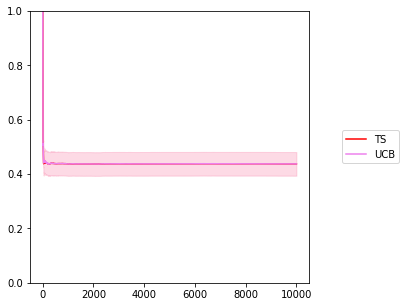

In [15]:
# plot estimation error (theta_1)
fig, ax = plt.subplots(figsize=(5, 5))
#ax.fill_between(x, y0-y0_std, y0+y0_std, color = 'green', alpha=0.2)
TS_est_1_mean = TS_estimation_err_sum[:, 1] / n_experiment
TS_est_1_sd = (TS_estimation_err_sum2[:, 1] - TS_est_1_mean ** 2) ** 0.5 / (n_experiment)
UCB_est_1_mean = UCB_estimation_err_sum[:, 1] / n_experiment
UCB_est_1_sd = (UCB_estimation_err_sum2[:, 1] - UCB_est_1_mean ** 2) ** 0.5 / (n_experiment)
ax.plot(np.arange(T), TS_est_1_mean, color = 'red', markersize=0.2, label = 'TS')
ax.plot(np.arange(T), UCB_est_1_mean, color = 'violet', markersize=0.2, label = 'UCB')
ax.fill_between(np.arange(T), TS_est_1_mean - TS_est_1_sd, \
                TS_est_1_mean + TS_est_1_sd, color = 'red', alpha=0.1)
ax.fill_between(np.arange(T), UCB_est_1_mean - UCB_est_1_sd, \
                UCB_est_1_mean + UCB_est_1_sd, color = 'violet', alpha=0.1)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
#ax.set_xlim([0, 10000])
#ax.set_xticks([0, 5000, 10000, 15000, 20000])
ax.set_ylim([0, 1])
#fig.savefig("7.pdf", format="pdf")
fig

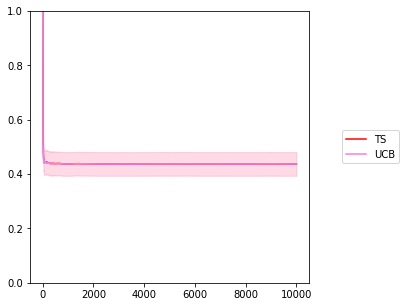

In [14]:
# plot estimation error (theta_0)
fig, ax = plt.subplots(figsize=(5, 5))
#ax.fill_between(x, y0-y0_std, y0+y0_std, color = 'green', alpha=0.2)
TS_est_0_mean = TS_estimation_err_sum[:, 0] / n_experiment
TS_est_0_sd = (TS_estimation_err_sum2[:, 0] - TS_est_0_mean ** 2) ** 0.5 / (n_experiment)
UCB_est_0_mean = UCB_estimation_err_sum[:, 0] / n_experiment
UCB_est_0_sd = (UCB_estimation_err_sum2[:, 0] - UCB_est_0_mean ** 2) ** 0.5 / (n_experiment)
ax.plot(np.arange(T), TS_est_0_mean, color = 'red', markersize=0.2, label = 'TS')
ax.plot(np.arange(T), UCB_est_0_mean, color = 'violet', markersize=0.2, label = 'UCB')
ax.fill_between(np.arange(T), TS_est_0_mean - TS_est_0_sd, \
                TS_est_0_mean + TS_est_0_sd, color = 'red', alpha=0.1)
ax.fill_between(np.arange(T), UCB_est_0_mean - UCB_est_0_sd, \
                UCB_est_0_mean + UCB_est_0_sd, color = 'violet', alpha=0.1)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
#ax.set_xlim([0, 10000])
#ax.set_xticks([0, 5000, 10000, 15000, 20000])
ax.set_ylim([0, 1])
#fig.savefig("7.pdf", format="pdf")
fig

In [12]:
TS_est_0_mean

array([1.        , 0.97657888, 0.89903527, ..., 0.43728815, 0.4372917 ,
       0.437294  ])

In [13]:
TS_est_1_mean

array([1.        , 0.9734967 , 0.89145104, ..., 0.43751157, 0.43750952,
       0.43751335])

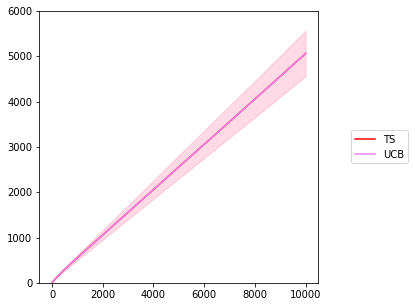

In [16]:
# plot regret
fig, ax = plt.subplots(figsize=(5, 5))
UCB_regret_mean = UCB_regret_err_sum / n_experiment
UCB_regret_sd = (UCB_regret_err_sum2 - UCB_regret_mean ** 2) ** 0.5 / (n_experiment)
TS_regret_mean = TS_regret_err_sum / n_experiment
TS_regret_sd = (TS_regret_err_sum2 - TS_regret_mean ** 2) ** 0.5 / (n_experiment)
#ME_regret_mean = ME_regret_err_sum / n_experiment
#ME_regret_sd = (ME_regret_err_sum2 - ME_regret_mean ** 2) ** 0.5 / (n_experiment)
#ME_n_regret_mean = ME_n_regret_err_sum / n_experiment
#ME_n_regret_sd = (ME_n_regret_err_sum2 - ME_n_regret_mean ** 2) ** 0.5 / (n_experiment)
#ax.plot(np.arange(T), ME_regret_err_sum / n_experiment, color = 'blue', markersize=0.2, label = 'MEB')
#ax.plot(np.arange(T), ME_n_regret_err_sum / n_experiment, color = 'green', markersize=0.2, label = 'MEB_naive')
ax.plot(np.arange(T), TS_regret_mean, color = 'red', markersize=0.2, label = 'TS')
ax.plot(np.arange(T), UCB_regret_mean, color = 'violet', markersize=0.2, label = 'UCB')
#ax.fill_between(np.arange(T), ME_regret_mean - ME_regret_sd, \
#                ME_regret_mean + ME_regret_sd, color = 'blue', alpha=0.1)
#ax.fill_between(np.arange(T), ME_n_regret_mean - ME_n_regret_sd, \
#                ME_n_regret_mean + ME_n_regret_sd, color = 'green', alpha=0.1)
ax.fill_between(np.arange(T), TS_regret_mean - TS_regret_sd, \
                TS_regret_mean + TS_regret_sd, color = 'red', alpha=0.1)
ax.fill_between(np.arange(T), UCB_regret_mean - UCB_regret_sd, \
                UCB_regret_mean + UCB_regret_sd, color = 'violet', alpha=0.1)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
#ax.set_xlim([0, 20000])
#ax.set_xticks([0, 5000, 10000, 15000, 20000])
#ax.set_xlim([0, 10000])
#ax.set_xticks([0, 2500, 5000, 7500, 10000])
#ax.set_xlim([0, 10000])
#ax.set_xticks([0, 2500, 5000, 7500, 10000])
ax.set_ylim([0, 6000])
#fig.savefig("8.pdf", format="pdf")
fig

In [16]:
np.mean(ME_history['at_list'] != ME_history['at_dag_list'])

0.06715865682686346

In [17]:
np.mean(UCB_history['at_list'] != UCB_history['at_dag_list'])

0.05725885482290354

In [18]:
print(TS_est_1_mean[-1], TS_est_1_sd[-1])
print(ME_est_1_mean[-1], ME_est_1_sd[-1])
print(ME_n_est_1_mean[-1], ME_n_est_1_sd[-1])

0.00953130966478182 0.0030226257632393547
0.001432803780325856 0.00046066716311827475
0.004916243975077221 0.0015896085612874683


In [19]:
print(TS_regret_mean[-1], TS_regret_sd[-1])
print(ME_regret_mean[-1], ME_regret_sd[-1])
print(ME_n_regret_mean[-1], ME_n_regret_sd[-1])

1.4970634701129981 0.48050701951340796
2.6064130978591264 0.8423614527617207
6.836600049914643 2.2154570557423474
